# Introduction

This notebook is used to explore results in general, performing quick DE results or looking at expression of certain genes in UMAP space.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import sparse
import warnings
import itertools as it
import json
import seaborn as sns
import pickle as pkl
from functools import reduce
import gc
import timeit

from nero import Nero as nr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

## Load in Data

In [4]:
path = prefix_comb + 'h5ads/concat_5.h5ad'
# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

In [12]:
concat.obsm['X_umap']

array([[ -3.6252222,   9.230064 ],
       [ -1.3476787,   6.3715477],
       [ -5.551411 , -11.817153 ],
       ...,
       [ -1.4935483,   2.255933 ],
       [  5.350238 , -11.410318 ],
       [  2.157029 , -11.410807 ]], dtype=float32)

In [10]:
concat = concat[concat.obs['cond'] != '0'].copy()

In [23]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['ct_colors']['ct2']['hex']
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

## Functions

In [12]:
def specificity_plot(adata, feature, thresh=None, ct_type='ct2', 
                     cts=None, conds=None, bins=50, logy=True, fontsize=12,
                     from_zero=False
                    ):
    '''
    Create a figure with 2 histograms and a scatter plot showing the distribution 
    of expression levels over all cells in adata, restricting to `cts` and `conds`.
    The first histogram shows the distribution across all cells, the second shows
    the same distribution broken up by `cond`. The scatter plot shows the 
    percentage of and mean expression of cells above `thresh`. This can be used to
    filter cells with expression = 0. 
    
    '''
    vals = adata.obs_vector(feature)
    obs = adata.obs.copy()
    f_name = feature + '_violin'
    obs[f_name] = vals
    
    if isinstance(cts, type(None)):
        cts = np.unique(obs[ct_type])
    else:
        obs = obs[obs[ct_type].isin(cts)].copy()
    if isinstance(conds, type(None)):
        conds = np.unique(obs['cond'])
    else:
        obs = obs[obs['cond'].isin(conds)].copy()
    
    vals = obs[f_name].values
    if isinstance(thresh, type(None)):
        thresh = vals.min()
        
    thresh_str = '{:03.2f}'.format(thresh)
    
    fig = plt.figure(figsize=(10, 5))
    gs = plt.GridSpec(2, 2, figure=fig)
    hist1 = fig.add_subplot(gs[0, 0])
    hist2 = fig.add_subplot(gs[1, 0], sharex=hist1, sharey=hist1)
    scatter_ax = fig.add_subplot(gs[:, 1])
    
    hist1.hist(vals, bins=bins)
    if logy:
        hist1.set_yscale('log');
    scatter_data = list()
    for cond in conds:
        sub_vals = obs[obs['cond'] == cond][f_name].values
        hist2.hist(sub_vals, bins=bins, color=cond_colors[cond], alpha=0.5)
        if logy:
            hist2.set_yscale('log')
        
        pos_bool = (sub_vals >= thresh)
        num_pos = pos_bool.sum()
        tot_num = sub_vals.shape[0]
        if num_pos > 0:
            scatter_data.append((num_pos/tot_num, 
                                 sub_vals[pos_bool].mean(),
                                 cond_colors[cond]))
    if thresh != 0:
        hist1.vlines(thresh, *hist1.get_ylim(), color='k', linestyle='--')
        hist2.vlines(thresh, *hist2.get_ylim(), color='k', linestyle='--')
    scatter_df = pd.DataFrame(scatter_data, columns=['x', 'y', 'c'])
    scatter_ax.scatter(x=scatter_df['x'].values, y=scatter_df['y'].values, c=scatter_df['c'].values)
    
    if isinstance(from_zero, bool):
        scatter_ax.set_ylim((0, scatter_ax.get_ylim()[1]*1.1))
        scatter_ax.set_xlim((0, scatter_ax.get_xlim()[1]*1.1))
    elif from_zero == 'x':
        scatter_ax.set_xlim((0, scatter_ax.get_xlim()[1]*1.1))
    elif from_zero == 'y':
        scatter_ax.set_ylim((0, scatter_ax.get_ylim()[1]*1.1))
    
    hist1.set_title('Expression distribution', fontsize=fontsize)
    hist2.set_title('Expression distribution, by cond', fontsize=fontsize)
    scatter_ax.set_title('Percent by mean expression >= %s' % thresh_str, fontsize=fontsize)

    hist1.set_ylabel('Number of cells', fontsize=fontsize)
    hist2.set_ylabel('Number of cells', fontsize=fontsize)
    scatter_ax.set_ylabel('Mean expression of cells with %s >= %s' % (feature, thresh_str), fontsize=fontsize)

    hist1.set_xlabel('Expression of %s' % feature, fontsize=fontsize)
    hist2.set_xlabel('Expression of %s' % feature, fontsize=fontsize) 
    scatter_ax.set_xlabel('Percent of cells with %s >= %s' % (feature, thresh_str), fontsize=fontsize)
    plt.tight_layout()
    return

# Explore

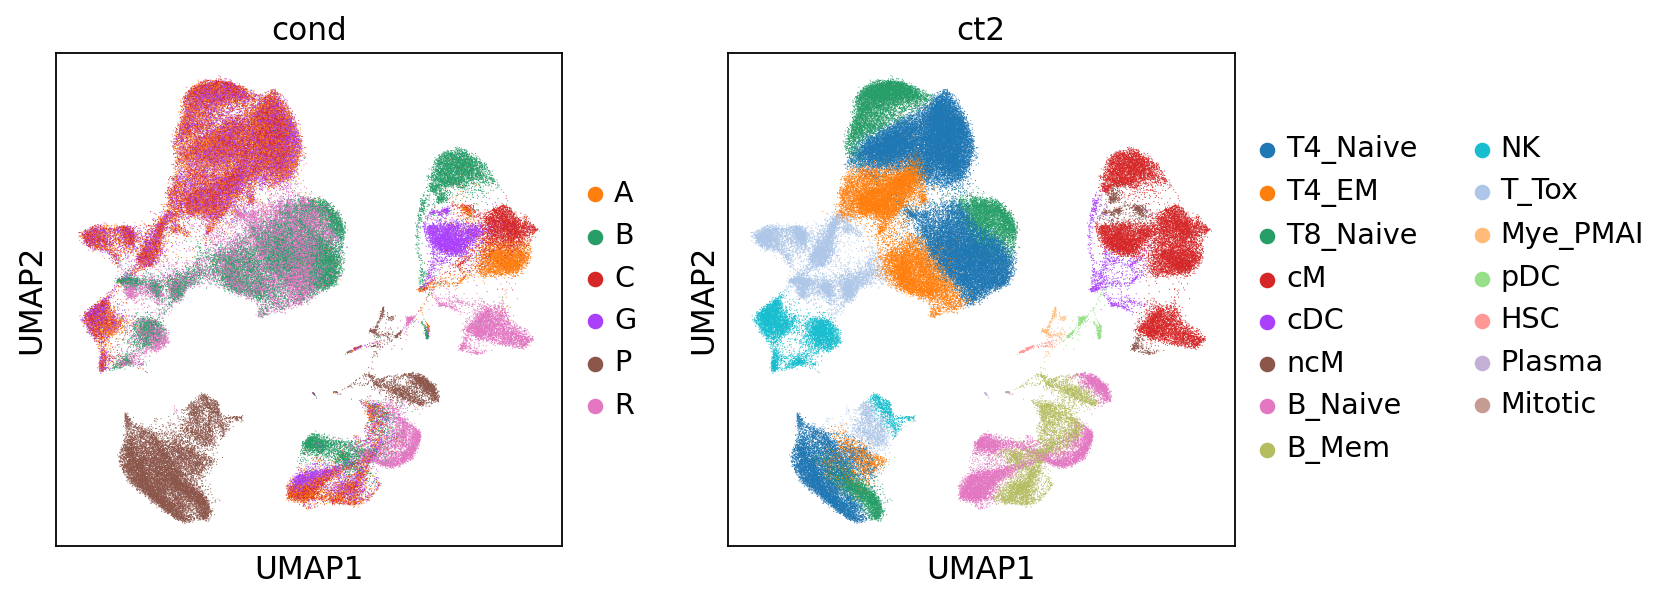

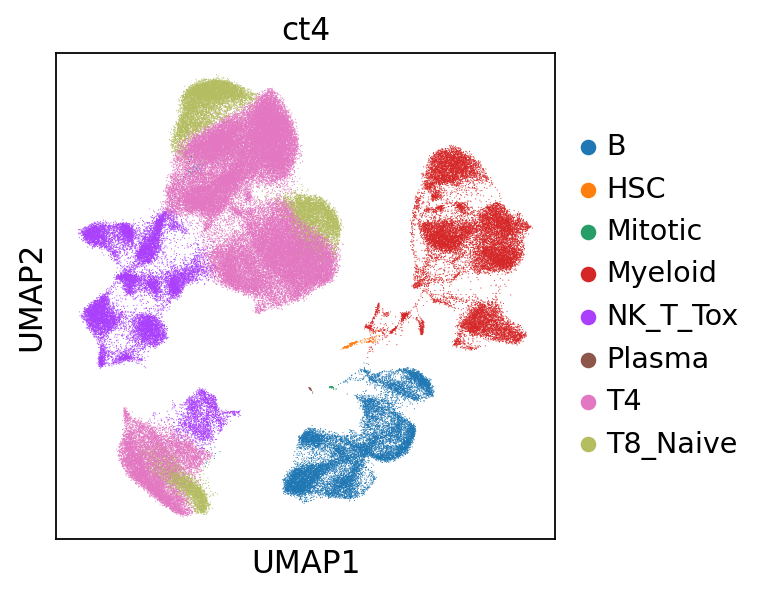

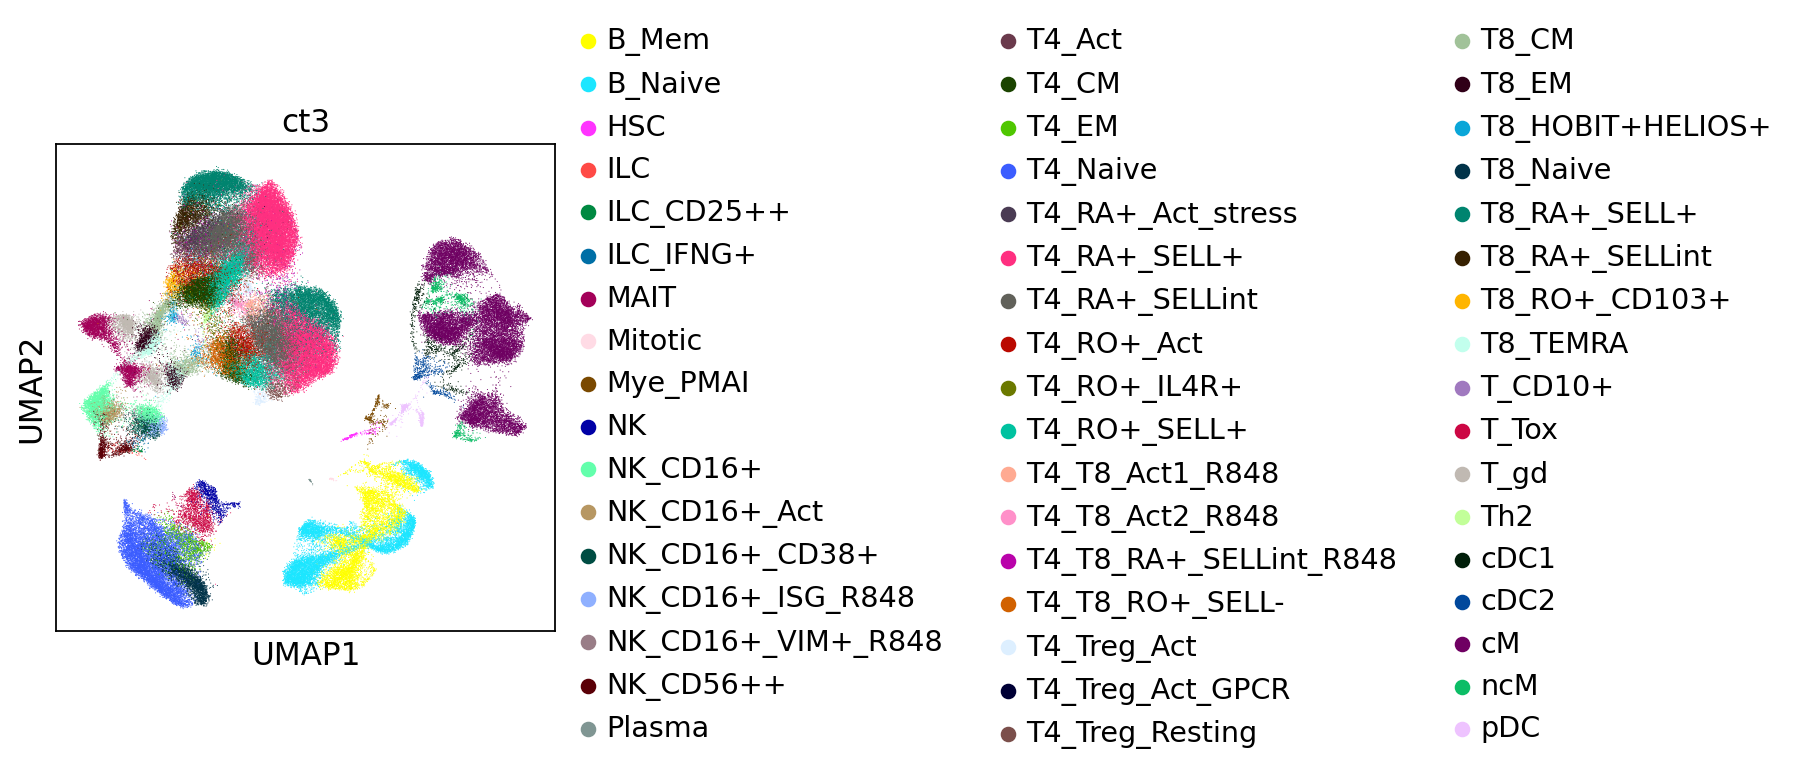

In [13]:
sc.pl.umap(concat, color=['cond', 'ct2'])
sc.pl.umap(concat, color=['ct4'])
sc.pl.umap(concat, color=['ct3'])

In [14]:
concat_T = concat[concat.obs['ct4'].isin(['T4', 'T8_Naive'])].copy()

In [15]:
concat_T.obs['ct3'].unique().tolist()

['T8_RA+_SELLint',
 'T4_RA+_SELL+',
 'T4_Naive',
 'T8_RA+_SELL+',
 'T4_CM',
 'T4_Treg_Act_GPCR',
 'T4_Treg_Resting',
 'T4_RA+_SELLint',
 'T4_Act',
 'T4_T8_RA+_SELLint_R848',
 'T4_RO+_SELL+',
 'T8_RO+_CD103+',
 'T4_Treg_Act',
 'T4_RO+_Act',
 'T4_RA+_Act_stress',
 'T8_Naive',
 'T4_T8_Act2_R848',
 'T4_T8_RO+_SELL-',
 'T4_RO+_IL4R+',
 'T4_EM',
 'T4_T8_Act1_R848',
 'Th2',
 'T_gd',
 'T8_CM',
 'MAIT',
 'T8_TEMRA',
 'T_CD10+',
 'T8_HOBIT+HELIOS+',
 'T8_EM']

In [16]:
# def highlight_clust(adata, key, clusts, bg='lightgray', bg_cells='gray', figsize=(8,8), other_label='other'):
#     '''
#     Highlight cluster(s) in UMAP space with background color.
    
#     `adata`: annotated data matrix
#     `key`: name of column in `adata.obs` with the clusters
#     `clusts`: member(s) of `adata.obs[key]` to highlight
#     `bg`: background color, accepted by matplotlib.ax.set_facecolor()
#     `bg_cells`: color of non-highlighted cells
#     `figsize`: size of resulting figure
#     `other_label`: key added to adata.obs used internally, but can be provided
#                    with str if default 'other' is already in use in adata.obs
    
#     returns: `ax`, matplotlib Axes object
#     '''
    
#     if isinstance(clusts, str):
#         label = key + ':' + clusts
#         clusts = [clusts]
#     elif isinstance(clusts, list):
#         clusts_len = len(clusts)
#         if clusts_len <= 3:
#             label = key + ':' + '&'.join(clusts)
#         else:
#             label = key + ':' + str(clusts_len) + '_clusts'
        
#     other_clusts = np.setdiff1d(np.unique(adata.obs[key]), clusts)
#     adata.obs[label] = adata.obs[key].copy()
#     adata.obs[label].replace(dict(it.product(other_clusts, [other_label])), inplace=True)
#     adata.obs[label] = adata.obs[label].astype('category')
#     adata.obs[label].cat.reorder_categories(new_categories=[other_label] + clusts, ordered=True, inplace=True)
    
#     key_cdict = dict(zip(adata.obs[key].cat.categories, adata.uns[key + '_colors']))
#     label_cdict = dict()
#     for clust in adata.obs[label].cat.categories:
#         if clust == other_label:
#             label_cdict[clust] = bg_cells
#         else:
#             label_cdict[clust] = key_cdict[clust]
    
#     adata.uns[label + '_colors'] = list(label_cdict.values())
    
#     fig, ax = plt.subplots(1, 1, figsize=figsize)
#     ax.set_facecolor(bg)
#     sc.pl.umap(adata, color=label, ax=ax, return_fig=False, show=False, size=20, sort_order=True)
#     adata.obs.drop(columns=[label], inplace=True)
#     return ax

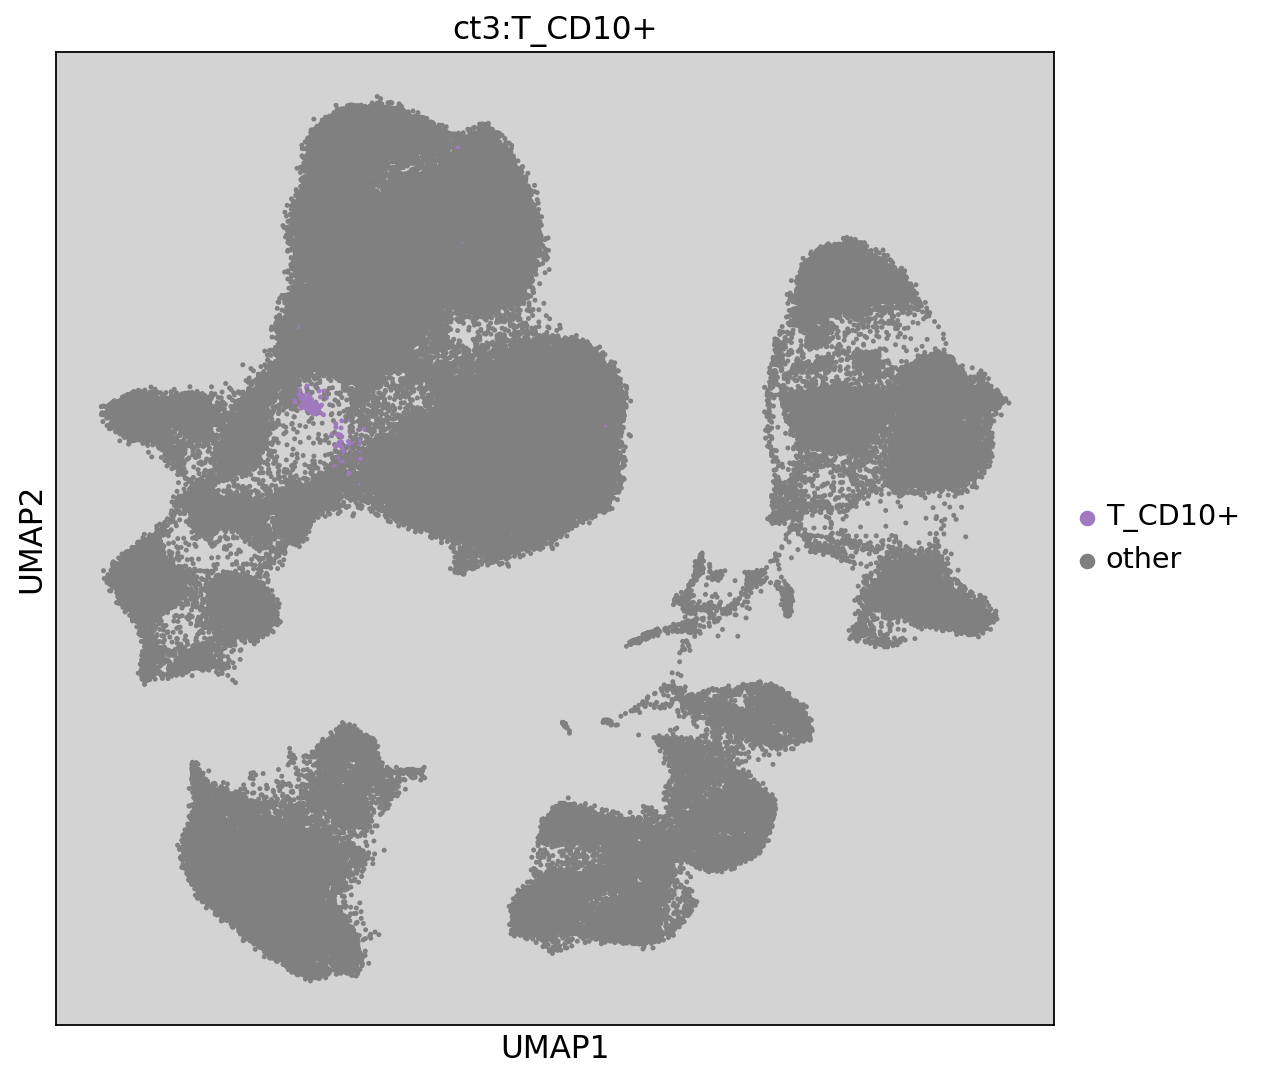

In [19]:
nr. highlight_clust(concat, 'ct3', 'T_CD10+');

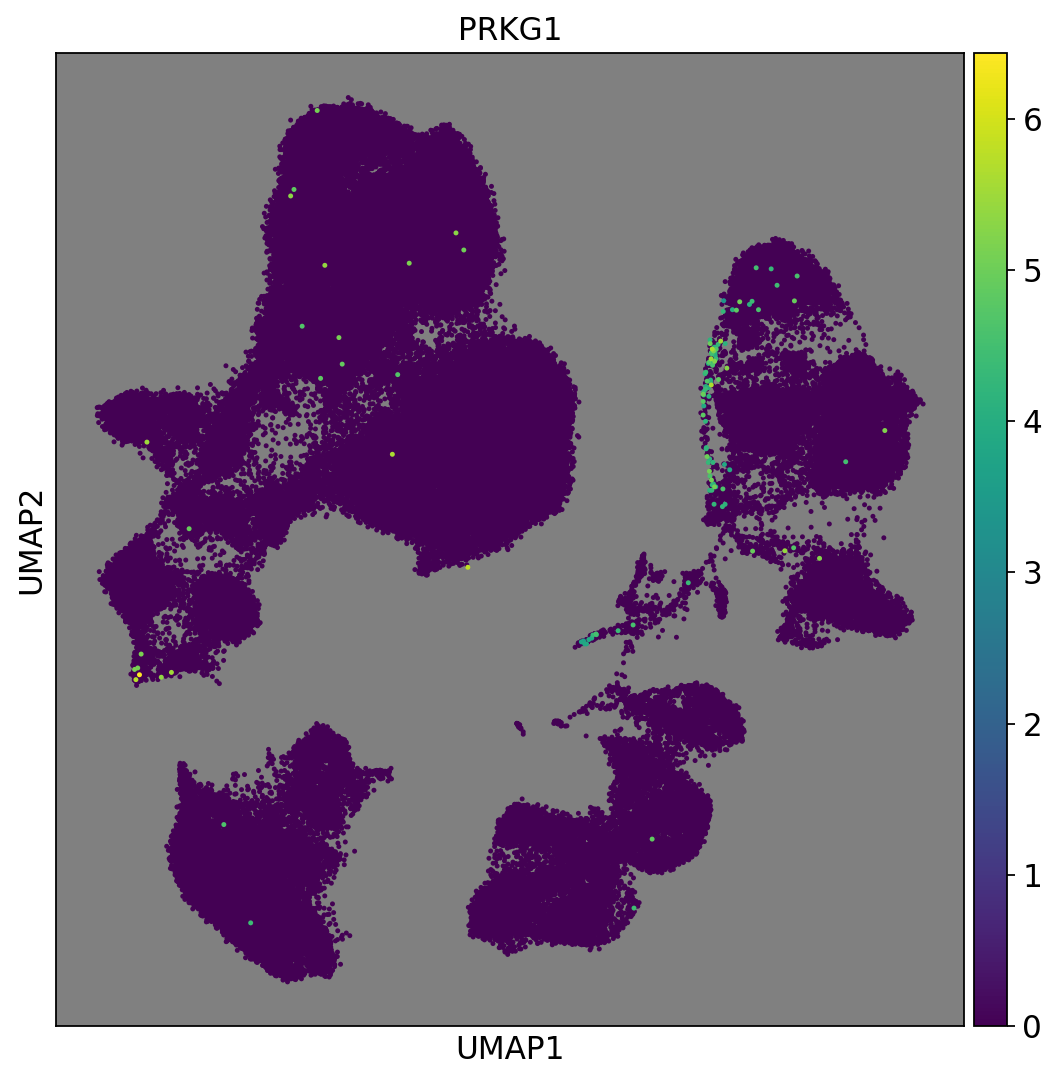

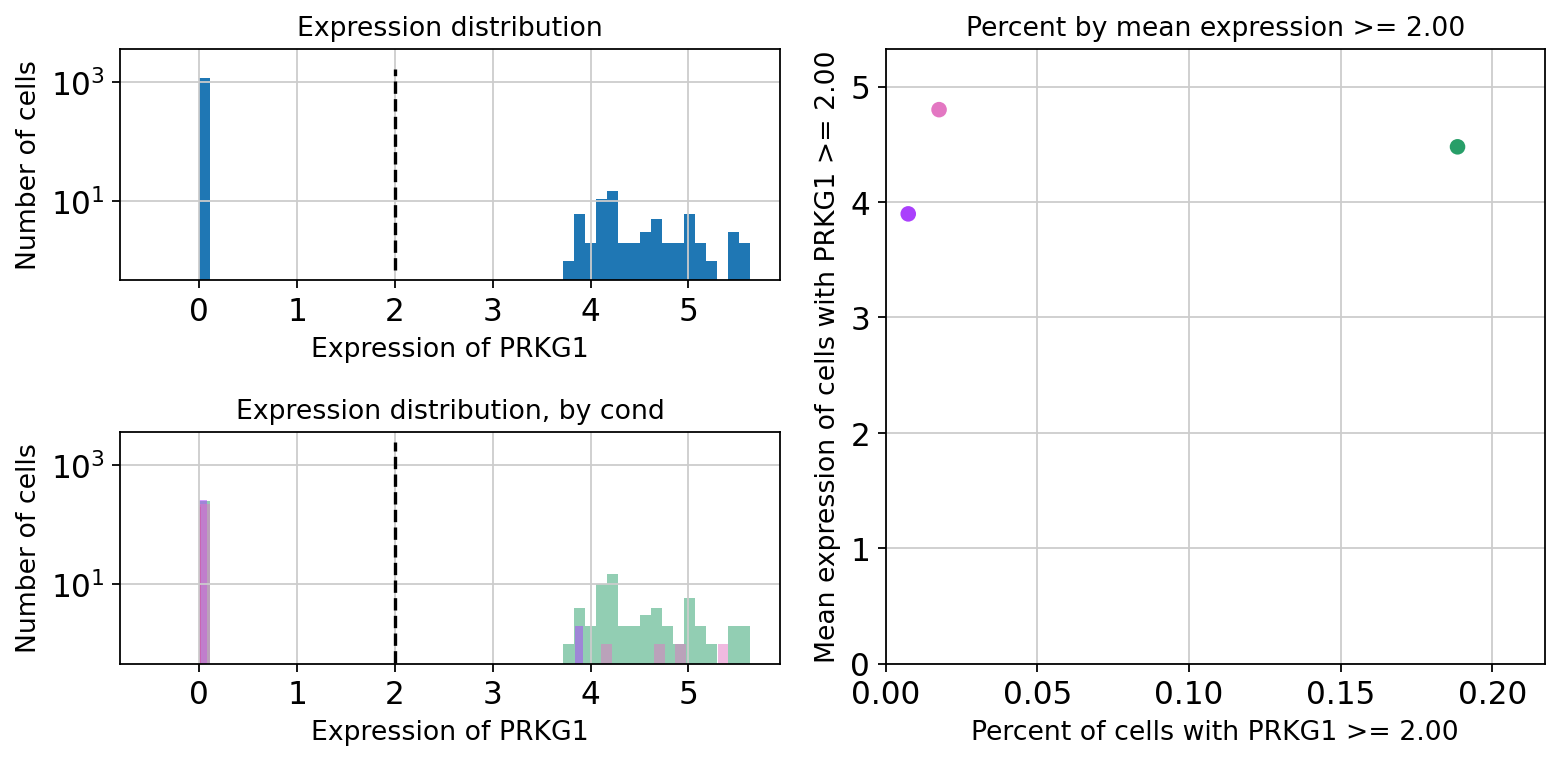

In [20]:
feature = 'PRKG1'
nr.highlight_feature(concat, feature);
specificity_plot(concat, feature, thresh=2, ct_type='ct2', cts=['cDC'], logy=True)

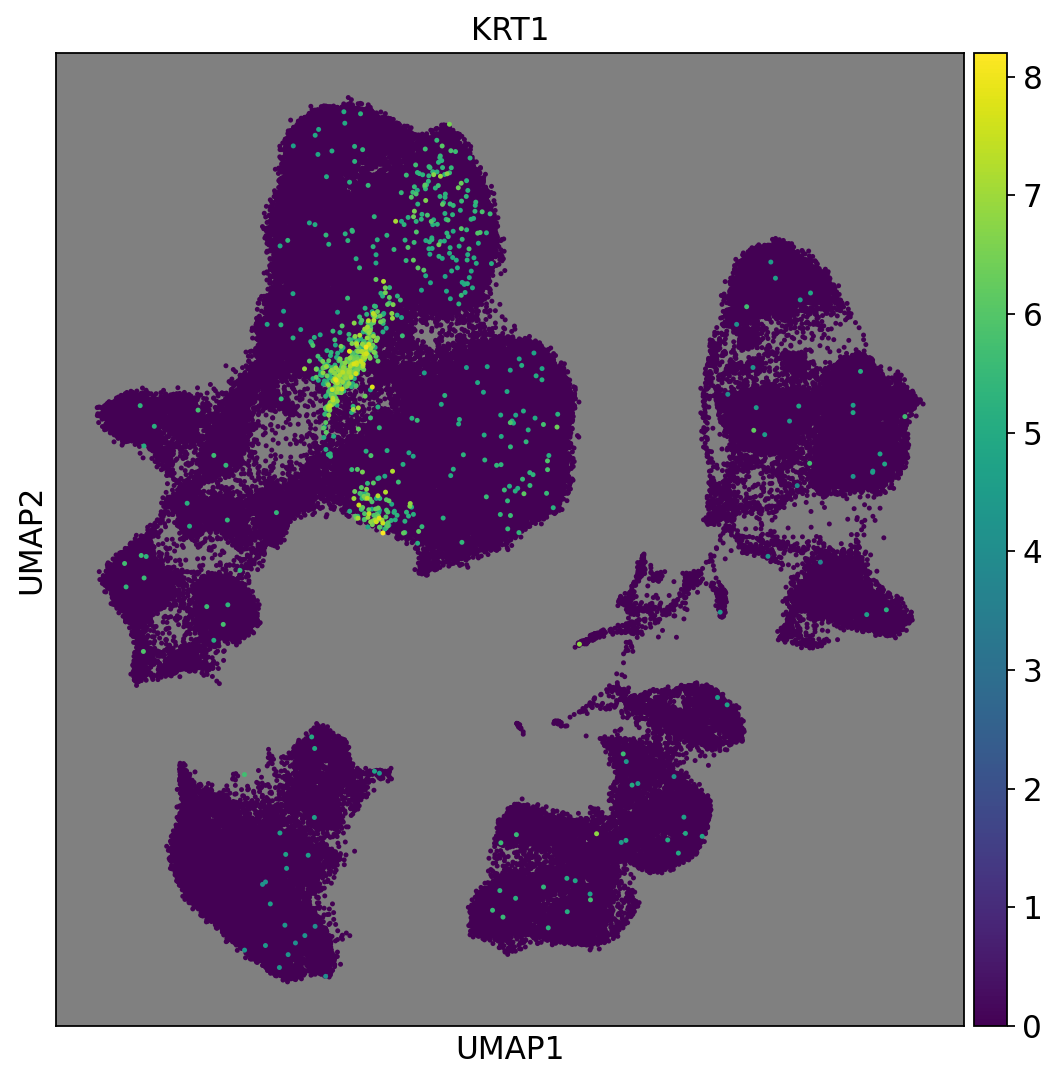

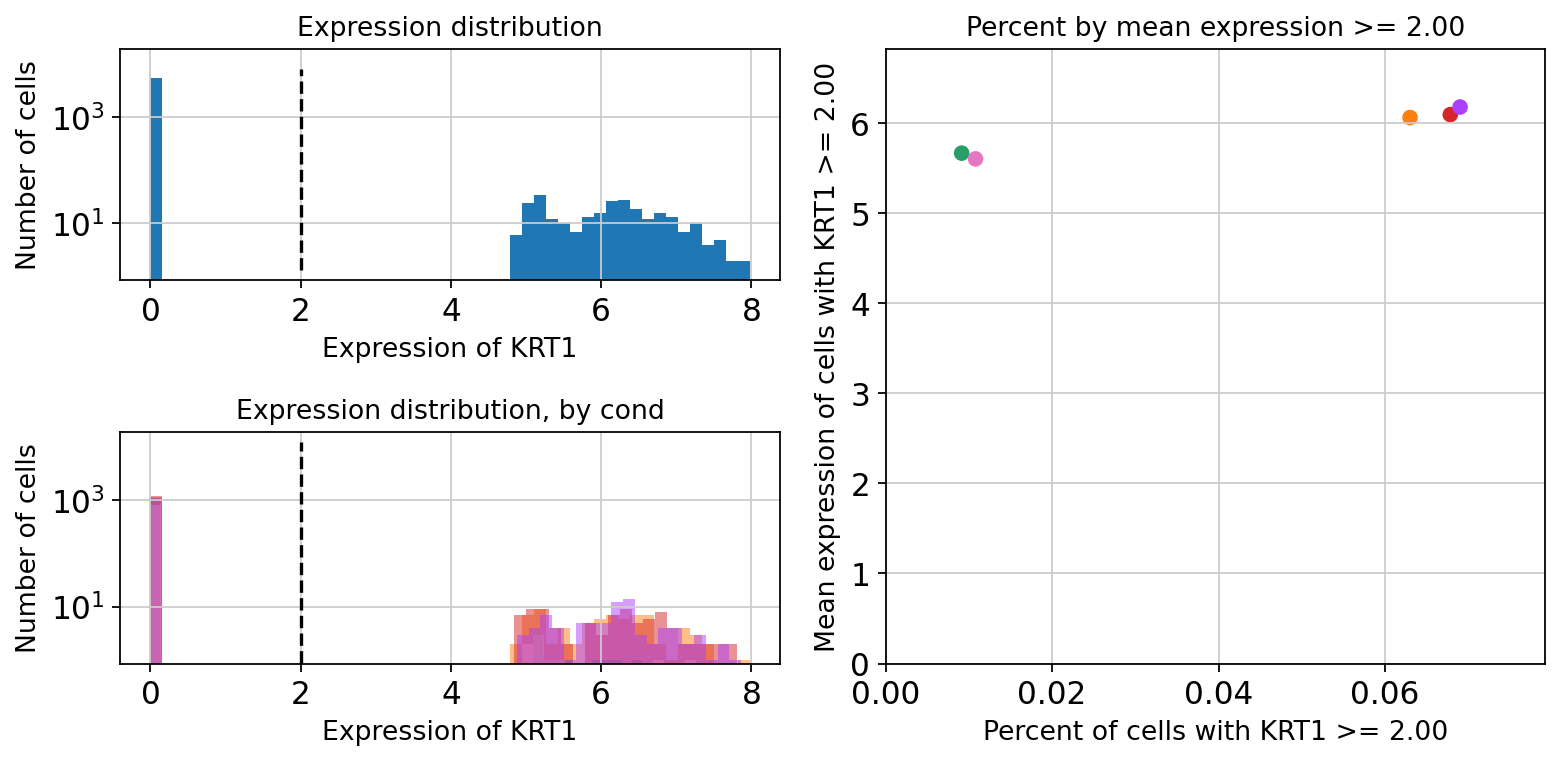

In [24]:
feature = 'KRT1'
nr.highlight_feature(concat, feature);
specificity_plot(concat, feature, thresh=2, ct_type='ct3', cts=['T4_RO+_SELL+'], logy=True)

In [122]:
concat.obs['ct2-cond'] = (concat.obs['ct2'].astype(str) + '-' + concat.obs['cond'].astype(str)).astype('category')

In [137]:
concat_mye = concat[concat.obs['ct4'] == 'Myeloid'].copy()

In [138]:
key = 'ct2-cond'
g1 = ['cDC-G']
g2 = [i for i in concat_mye.obs[key].cat.categories if i not in g1]
nr.add_lowde(concat_mye, key=key, groups=[g1, g2])

In [139]:
nr.low_de_compare(concat_mye, compare=(g1, g2), p=0.1, p_of=g1[0])

OR2I1P      26.058285
UBD         13.729796
PDGFRA       7.395189
CLEC10A      6.761702
IDO2         6.724444
              ...    
CXCL3        0.322129
RASGEF1B     0.310445
GAPT         0.294756
LHFPL2       0.269419
MAFB         0.255887
Length: 7619, dtype: float64

In [142]:
feature = 'CLEC10A'

nr.highlight_feature(concat, feature);
specificity_plot(concat, feature, thresh=2, ct_type='ct2', cts=['cDC'], logy=True)